In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


In [15]:
train= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

x_train = train.drop('label', axis = 1)
y_train = train["label"]

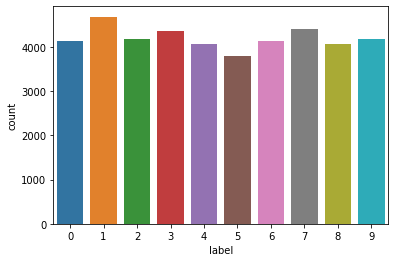

In [16]:
sns.countplot(y_train);

In [17]:
# Normalize the data
x_train = x_train / 255
test = test / 255

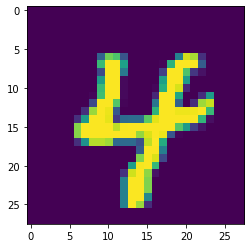

In [18]:
i = 49
plt.imshow(x_train.iloc[i].values.reshape((28, 28)));

In [19]:
y_train = to_categorical(y_train, num_classes = 10)

In [20]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [21]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

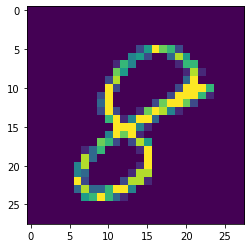

In [22]:
plt.imshow(x_train[0][:,:,0]);

In [23]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


In [24]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [25]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [26]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [27]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [28]:
# Without data augmentation i obtained an accuracy of 0.98114
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (x_val, y_val), verbose = 1);

Train on 37800 samples, validate on 4200 samples
Epoch 1/1
37800/37800 [==============================] - 113s 3ms/step - loss: 0.2428 - accuracy: 0.9228 - val_loss: 0.0631 - val_accuracy: 0.9795


In [29]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [30]:
# Fit the model
model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (x_val,y_val),
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                    , callbacks=[learning_rate_reduction]);

Epoch 1/1
439/439 [==============================] - 117s 267ms/step - loss: 0.1708 - accuracy: 0.9477 - val_loss: 0.0481 - val_accuracy: 0.9829


C:\Users\Aldo Franco\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [ ]:
# predict results
results = model.predict(test, verbose=1)

11008/28000 [==========>...................] - ETA: 7s

In [ ]:
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist.csv",index=False)
